In [2]:
# Лабораторная работа №3
# Светлаковой Ульяны
import pandas as pd
import numpy as np

In [3]:
file_path = 'lab_3_adcp_data.txt'
df = pd.read_csv(file_path, delim_whitespace=True)
df.head()

,Station,Longitude,Latitude,Depth,Ve,Vn
0,41067,19.894209,54.628962,2.11,-19.180,28.436
1,41067,19.894209,54.628962,2.61,-5.096,-1.816
2,41068,19.894209,54.628994,2.11,6.196,-51.428
3,41068,19.894209,54.628994,2.61,-16.006,-10.088
4,41069,19.894210,54.629025,2.11,-37.174,3.625


In [4]:
df = df.apply(pd.to_numeric, errors='ignore')

# Сортировка по станциям и глубинам 
df = df.sort_values(by=['Station', 'Depth'])

In [5]:
# Интегрирование скорости потока по глубине для станции
def integral_by_depth(df, station, component, method):
    # Фильтруем данные для указанной станции
    station_data = df[df['Station'] == station]
    depths = station_data['Depth'].values.astype(float)
    values = station_data[component].values.astype(float)

    if method == 'left':
        # Метод левых прямоугольников: суммируем произведения высот и шагов интегрирования
        integral = 0.0
        for i in range(len(values) - 1):
            height = values[i]  # Высота (значение скорости)
            width = depths[i + 1] - depths[i]  # Ширина (шаг по глубине)
            integral += height * width  # Площадь прямоугольника

    elif method == 'right':
        # Метод правых прямоугольников: используем значения правых прямоугольников
        integral = 0.0
        for i in range(1, len(values)):
            height = values[i]  
            width = depths[i] - depths[i - 1]
            integral += height * width 

    elif method == 'trapezoidal':
        # Метод трапеций: суммируем площади трапеций, образованных соседними точками
        integral = 0.0
        for i in range(len(values) - 1):
            height1 = values[i]  # Высота первой точки
            height2 = values[i + 1]  # Высота второй точки
            width = depths[i + 1] - depths[i] 
            integral += 0.5 * (height1 + height2) * width  # Площадь трапеции

    elif method == 'simpson':
        # Метод Симпсона: точное интегрирование для равномерного шага (должно быть четное число точек)
        if len(values) < 3 or (len(values) - 1) % 2 == 0:
            raise ValueError("Для метода Симпсона требуется нечетное количество точек.")
        
        h = (depths[-1] - depths[0]) / (len(depths) - 1)  # Шаг интегрирования
        integral = values[0] + values[-1]  # Начальные и конечные значения
        for i in range(1, len(values) - 1):
            if i % 2 == 0:
                integral += 2 * values[i]  # Четные индексы
            else:
                integral += 4 * values[i]  # Нечетные индексы
        
        integral *= h / 3  # Умножаем на шаг интегрирования

    else:
        raise ValueError(f"Метод {method} не поддерживается.")

    return integral

In [6]:
# Расчет интеграла по глубине для каждой станции для компоненты Ve и Vn
integrals_ve = {}
integrals_vn = {}

# Пусть будет метод трапеции
for station in df['Station'].unique():
    integrals_ve[station] = integral_by_depth(df, station, component='Ve', method='trapezoidal')
    integrals_vn[station] = integral_by_depth(df, station, component='Vn', method='trapezoidal')

print("Первые 10 значений интеграла от Ve по глубине для каждой станции:")
for station, value in list(integrals_ve.items())[:10]:
    print(f"Станция: {station}, Интеграл Ve: {value}")

print("\nПервые 10 значений интеграла от Vn по глубине для каждой станции:")
for station, value in list(integrals_vn.items())[:10]:
    print(f"Станция: {station}, Интеграл Vn: {value}")

Первые 10 значений интеграла от Ve по глубине для каждой станции:
Станция: 41067, Интеграл Ve: -6.069
Станция: 41068, Интеграл Ve: -2.4525
Станция: 41069, Интеграл Ve: -1.8224999999999998
Станция: 41070, Интеграл Ve: -8.026
Станция: 41071, Интеграл Ve: -1.8067499999999999
Станция: 41072, Интеграл Ve: 0.4002500000000011
Станция: 41073, Интеграл Ve: 9.9195
Станция: 41074, Интеграл Ve: -0.724
Станция: 41075, Интеграл Ve: -6.66775
Станция: 41076, Интеграл Ve: 9.53975

Первые 10 значений интеграла от Vn по глубине для каждой станции:
Станция: 41067, Интеграл Vn: 6.655
Станция: 41068, Интеграл Vn: -15.379
Станция: 41069, Интеграл Vn: 9.3775
Станция: 41070, Интеграл Vn: 4.0745000000000005
Станция: 41071, Интеграл Vn: -4.85475
Станция: 41072, Интеграл Vn: -23.82
Станция: 41073, Интеграл Vn: -18.01525
Станция: 41074, Интеграл Vn: -2.6395
Станция: 41075, Интеграл Vn: -6.016
Станция: 41076, Интеграл Vn: -3.1162500000000004


In [7]:
# интегрирование по пространству для уже проинтегрированных значений скорости по глубине
def integral_by_stations(integrals, station_positions, method):
    
    if method == 'left':
        # Метод левых прямоугольников: суммируем произведения высот и шагов по пространству
        integral = 0.0
        for i in range(len(integrals) - 1):
            height = integrals[list(integrals.keys())[i]]  # Значение интеграла на текущей станции
            width = station_positions[list(station_positions.keys())[i + 1]] - station_positions[list(station_positions.keys())[i]]  # Ширина (расстояние между станциями)
            integral += height * width  # Площадь прямоугольника

    elif method == 'right':
        # Метод правых прямоугольников: аналогично, но используем правые значения
        integral = 0.0
        for i in range(1, len(integrals)):
            height = integrals[list(integrals.keys())[i]]  # Значение интеграла на текущей станции
            width = station_positions[list(station_positions.keys())[i]] - station_positions[list(station_positions.keys())[i - 1]]  # Ширина (расстояние между станциями)
            integral += height * width  # Площадь прямоугольника

    elif method == 'trapezoidal':
        # Метод трапеций: усредняем значения интегралов между соседними станциями
        integral = 0.0
        for i in range(len(integrals) - 1):
            height1 = integrals[list(integrals.keys())[i]]  # Интеграл на первой станции
            height2 = integrals[list(integrals.keys())[i + 1]]  # Интеграл на следующей станции
            width = station_positions[list(station_positions.keys())[i + 1]] - station_positions[list(station_positions.keys())[i]]  # Ширина (расстояние между станциями)
            integral += 0.5 * (height1 + height2) * width  # Площадь трапеции

    elif method == 'simpson':
        # Метод Симпсона: требуется нечетное количество станций
        if len(integrals) < 3 or (len(integrals) - 1) % 2 == 0:
            raise ValueError("Для метода Симпсона требуется нечетное количество станций (минимум 3).")
        
        h = (station_positions[list(station_positions.keys())[-1]] - station_positions[list(station_positions.keys())[0]]) / (len(station_positions) - 1)  # Шаг интегрирования
        integral = integrals[list(integrals.keys())[0]] + integrals[list(integrals.keys())[-1]]  # Начальные и конечные значения
        for i in range(1, len(integrals) - 1):
            if i % 2 == 0:
                integral += 2 * integrals[list(integrals.keys())[i]]  # Четные индексы
            else:
                integral += 4 * integrals[list(integrals.keys())[i]]  # Нечетные индексы
        
        integral *= h / 3  # Умножаем на шаг интегрирования

    else:
        raise ValueError(f"Метод {method} не поддерживается.")

    return integral

In [8]:
# Позиция каждой станции
station_positions = {station: i for i, station in enumerate(df['Station'].unique())}

# Общий поток воды
total_integral_ve = integral_by_stations(integrals_ve, station_positions, method='trapezoidal')
total_integral_vn = integral_by_stations(integrals_vn, station_positions, method='trapezoidal')

print("Объем перемещения воды в восточном направлении Ve по станциям", total_integral_ve)
print("Объем перемещения воды в северном направлении Vn по станциям", total_integral_vn)

Объем перемещения воды в восточном направлении Ve по станциям 849183.445749996
Объем перемещения воды в северном направлении Vn по станциям -409494.4001249985


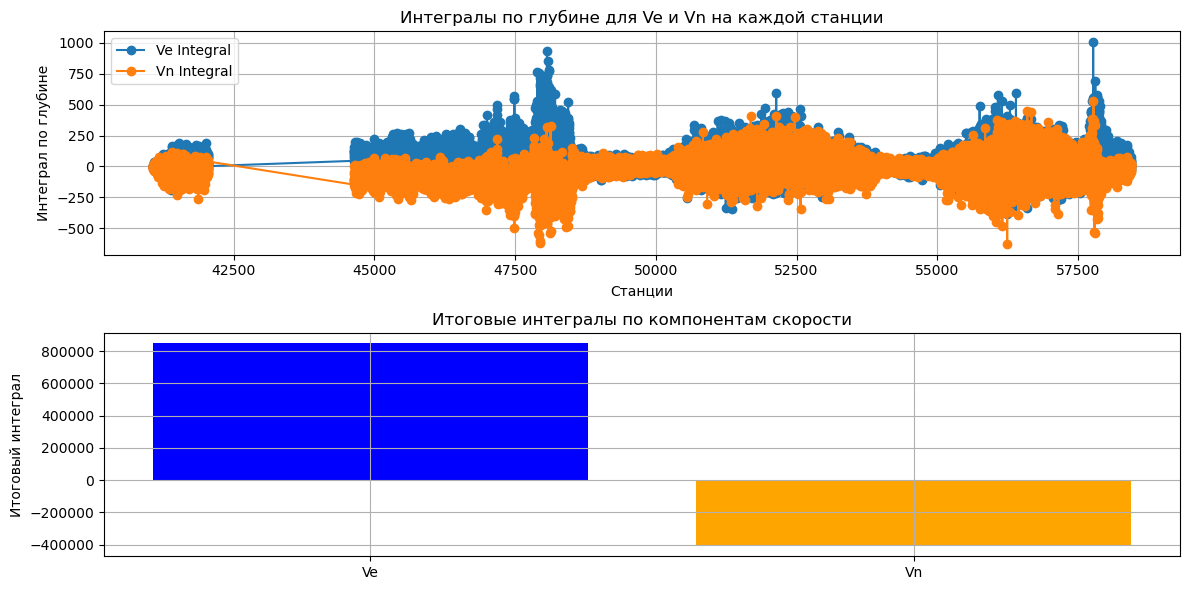

In [9]:
import matplotlib.pyplot as plt

stations = list(station_positions.keys())  # Номера станций
depth_integrals = [integrals_ve[station] for station in stations]  # Интегралы Ve
depth_integrals_vn = [integrals_vn[station] for station in stations]  # Интегралы Vn

# График интегралов по глубине
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stations, depth_integrals, label='Ve Integral', marker='o')
plt.plot(stations, depth_integrals_vn, label='Vn Integral', marker='o')
plt.xlabel('Станции')
plt.ylabel('Интеграл по глубине')
plt.title('Интегралы по глубине для Ve и Vn на каждой станции')
plt.legend()
plt.grid()

# Диаграмма итоговых интегралов
plt.subplot(2, 1, 2)
plt.bar(['Ve', 'Vn'], [total_integral_ve, total_integral_vn], color=['blue', 'orange'])
plt.ylabel('Итоговый интеграл')
plt.title('Итоговые интегралы по компонентам скорости')
plt.grid()

plt.tight_layout()
plt.show()
